In [ ]:
!pip install catboost

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import datetime
from sklearn.preprocessing import MinMaxScaler
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import time

In [50]:
sns.set_style("whitegrid")

### Read Data

In [51]:
PATH = "Data/"

valid_df = pd.read_csv(PATH + "validation_data_1.csv", delimiter=",")
train_df = pd.read_pickle(PATH + "selected_data.pickle")
gen_train_df = pd.read_csv(PATH + "train_data.csv")

### Functions Declarations

In [52]:
def get_all_timestamps(min_v: int, max_v: int, name: str = "timestamp") -> pd.DataFrame:
    delta = datetime.timedelta(hours=1)
    min_v = datetime.datetime.fromtimestamp(min_v)
    max_v = datetime.datetime.fromtimestamp(max_v)
    value = min_v
    values = [value, ]
    while value != max_v:
        value += delta
        values.append(value)
    values = list(map(lambda x: x.timestamp(), values))
    df = pd.DataFrame()
    df[name] = values
    return df


def get_dynamics(point, gen_train_df):
    """Extract dynamics for certain point."""
    
    all_timestamps = get_all_timestamps(gen_train_df.timestamp.min(), gen_train_df.timestamp.max())
    for pt, g in gen_train_df.groupby("point"):
        if pt != point:
            continue
        g = g.groupby("timestamp").apply(len).to_frame("n_pubs").reset_index(drop=False)
        g = g.merge(all_timestamps, how="outer", on="timestamp")
        g = g.fillna(0)

        g_train = g.set_index("timestamp").sort_index()["n_pubs"]
        if len(g_train) == 0:
            continue
    return g_train

In [53]:
def get_hours(n, num):
    k = n // num + 1
    pattern = np.vstack((np.zeros(num - 1), np.eye(num - 1, num - 1)))
    res = np.tile(pattern, (k, 1))
    res = res[:n]
    return res

def get_days(n, num):
    k = n // num // 24 + 1
    pattern = np.vstack((np.zeros(num - 1), np.eye(num - 1, num - 1)))
    pattern = np.repeat(pattern, 24, axis=0)
    res = np.tile(pattern, (k, 1))
    res = res[:n]
    return res

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

def MSE(true, pred):
    return np.mean((true-pred) ** 2)

In [54]:
def dataset_preprocessing(data, n, num_pred):
    data_df = pd.DataFrame({'timestamp': np.arange(n+num_pred)})
    data_df['n_pubs'] = np.append(data.values, np.zeros(num_pred))

    l = data_df.shape[1]
    data_df.insert(l, 'const', np.ones(n+num_pred), True)
    hours = get_hours(n+num_pred, 24)
    days = get_days(n+num_pred, 7)

    l = data_df.shape[1]
    for i in range(23):
        data_df.insert(l + i, f'{i}', hours[:, i], True)

    l = data_df.shape[1]
    for i in range(6):
        data_df.insert(l + i, f'{i + 23}', days[:, i], True)

    scaler = MinMaxScaler()
    scaler.fit(data_df[["n_pubs"]][:-num_pred])

    data_df["n_pubs"] = np.append(np.array(scaler.transform(data_df[["n_pubs"]][:-num_pred])), np.zeros(num_pred))

    data_df['timestamp'] /= 10000
    
    return data_df, scaler

In [55]:
def fit_model(sample_data, NUM_PRED):
    # Preprocessing
    n = len(sample_data)

    sample_data_df, scaler = dataset_preprocessing(sample_data, n, NUM_PRED)

    y = sample_data_df.pop('n_pubs')
    x = sample_data_df

    x_train = x
    y_train = y

    x_train = x[:n]
    y_train = np.array(y[:n])
    x_test = x[n:]
    y_test = np.array(y[n:])

    # Fit the model
    model = CatBoostRegressor()
    model.fit(x_train, y_train, verbose=False)

    return model, scaler, x_test

In [56]:
def predict(model, x_test, scaler):
    # Get a prediction
    y_pred = model.predict(x_test)
    # Inverse scale for y_pred
    y_pred_invscale = scaler.inverse_transform(y_pred.reshape(-1, 1))
    # Replace all negative values with zeros
    for pred_id, pred_elem in enumerate(y_pred_invscale):
        if pred_elem[0] < 0.0:
            y_pred_invscale[pred_id][0] = 0.0
    
    return y_pred_invscale

In [57]:
def calculate_valid(valid_data, y_pred, pred_timestamps, point, file_valid):
    # Calculate error
    valid_data["hour"] = [datetime.datetime.fromtimestamp(valid_hour).strftime("%Y-%m-%d %H:%M:%S") 
                          for valid_hour in valid_data["hour"]]
    
    sum_err = []
    for valid_date in valid_data["hour"]:
        pub_sum = valid_data[valid_data["hour"]==valid_date]["sum"].values[0]
        pub_pred_id = np.where(np.array(pred_timestamps)==valid_date)[0][0]
        
        pub_pred = y_pred[pub_pred_id]

        err_mess = ""
        if np.isclose(pub_sum, 0.0):
            err_mess = "[WARNING]:zero_true_pub_sum"
            error = 1
        else:
            error = abs(pub_pred - pub_sum) / pub_sum

        time_info = time.mktime(datetime.datetime.strptime(valid_date,
                                                    "%Y-%m-%d %H:%M:%S").timetuple())

        # Save .log
        file_valid.write(f"{int(time_info)};{point};{pub_pred};{pub_sum};{error}\n")

In [58]:
def train_models(gen_dataset, train_df, NUM_PRED, file_name_predict):
    file_predict = open(f'{file_name_predict}.log', 'w')
    file_predict.write("point;timestamps;predict\n")
    
    all_points = list(set(gen_dataset["point"])) 
    
    end = datetime.datetime.fromtimestamp(train_df["groups"][0].index[-1])
    pred_timestamps = np.array([(end + datetime.timedelta(hours=i)).strftime("%Y-%m-%d %H:%M:%S") 
                                         for i in range(1, NUM_PRED+1)])
    
    for point in tqdm(all_points):
        TRAIN_FLAG = False
        sample_data = None
        point_id = None
        
        for i, pt in enumerate(train_df["points"]):
            if point == pt:
                TRAIN_FLAG = True 
                point_id = i
                # Extract dynamics
                sample_data = train_df["groups"][point_id]   
                break  
        if TRAIN_FLAG:        
            # Fit model
            model, scaler, x_pred = fit_model(sample_data, NUM_PRED)
            # Save model 
            model.save_model(f"Models/{point}_optFalse") 
            # Predict
            y_pred = predict(model, x_pred, scaler)
            # Save predictions
            end = datetime.datetime.fromtimestamp(sample_data.index[-1])
            pred_timestamps = np.array([(end + datetime.timedelta(hours=i)).strftime("%Y-%m-%d %H:%M:%S") 
                                         for i in range(1, NUM_PRED+1)])
            file_predict.write(f"{point};{pred_timestamps};{y_pred[:,0]}\n")
        else:
            y_pred = np.zeros(NUM_PRED)
            file_predict.write(f"{point};{pred_timestamps};{y_pred}\n")
            
    file_predict.close()       

In [59]:
def valid_models(predict_df, valid_df, file_name_valid):
    file_valid = open(f'{file_name_valid}.log', 'w')
    file_valid.write("hour;point;pred_sum;true_sum;error\n")
    
    metric_err = []
    
    for point in valid_df["point"]:
        point_id = None
        for i, pt in enumerate(predict_df["point"]):
            if point == pt:
                point_id = i
                # Extract predict
                timestamps_pred = predict_df["timestamps"][point_id]
                predict_data = predict_df["predict"][point_id]   
                break     
                
        valid_data = valid_df[valid_df["point"]==point]
            
        calculate_valid(valid_data, predict_data, timestamps_pred, point, file_valid)
    file_valid.close()   

In [60]:
FILE_NAME_PREDICT = "predict" 
NUM_PRED = 29 * 24

In [ ]:
train_models(gen_train_df, train_df, NUM_PRED, FILE_NAME_PREDICT)

### Check predictions on validation sets

In [89]:
predictions_file = "predict.log"
predict_info = open(predictions_file).read()

In [90]:
predict_info = predict_info.replace("]",";")
predict_info = predict_info.replace("\n","")
predict_info = predict_info.split(';') 

predict_info = [elem for elem in predict_info if len(elem) != 0]

In [91]:
columns_name = predict_info[:3]
predict_info = predict_info[3:]

points = [predict_info[i] for i in range(0, len(predict_info), 3)]
timestamps = [predict_info[i].replace("[", "").split("'") for i in range(1, len(predict_info), 3)]
predicted = [predict_info[i].replace("[", "").split(" ") for i in range(2, len(predict_info), 3)]

In [92]:
columns_name

['point', 'timestamps', 'predict']

In [93]:
predict_df = pd.DataFrame({columns_name[0]: points, 
                           columns_name[1]: timestamps, 
                           columns_name[2]: predicted})

In [94]:
for i in range(len(predict_df["predict"])):
    predict_df["predict"][i] = [round(float(elem)) for elem in predict_df["predict"][i] if len(elem) != 0]
for i in range(len(predict_df["timestamps"])):
    predict_df["timestamps"][i] = [elem for elem in predict_df["timestamps"][i] if len(elem) not in [0, 1]]

In [95]:
predict_df.head(10)

,point,timestamps,predict
0,0101000020E610000050EDAE60115A3E4021096A9925EE...,"[2020-02-01 03:00:00, 2020-02-01 04:00:00, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0101000020E61000005AB1738E63773E4081D63015A3F4...,"[2020-02-01 03:00:00, 2020-02-01 04:00:00, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0101000020E6100000E030027AF0733E40FBF1162D20EC...,"[2020-02-01 03:00:00, 2020-02-01 04:00:00, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0101000020E6100000FF83F06FD7633E40516FA59DABF8...,"[2020-02-01 03:00:00, 2020-02-01 04:00:00, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,0101000020E6100000770462844A673E40EC8BB6949A04...,"[2020-02-01 03:00:00, 2020-02-01 04:00:00, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,0101000020E61000005DECCB372B533E403DF3BDF39400...,"[2020-02-01 03:00:00, 2020-02-01 04:00:00, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,0101000020E610000002BF48199F3F3E408EC13E307EF4...,"[2020-02-01 03:00:00, 2020-02-01 04:00:00, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,0101000020E61000000FD8C18EA45A3E4070B5CC78A7F6...,"[2020-02-01 03:00:00, 2020-02-01 04:00:00, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,0101000020E61000005AB1738E63773E40CC6871B467FB...,"[2020-02-01 03:00:00, 2020-02-01 04:00:00, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,0101000020E6100000DCDB4D323D763E4072F37A6CE3F0...,"[2020-02-01 03:00:00, 2020-02-01 04:00:00, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [96]:
FILE_NAME_VALID1 = "valid_1"

valid_models(predict_df, valid_df, FILE_NAME_VALID1)

In [97]:
valid_df_1 = pd.read_csv(f"{FILE_NAME_VALID1}.log", sep=";")
valid_df_1.head(10)

,hour,point,pred_sum,true_sum,error
0,1582448400,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,3,5,0.400000
1,1582286400,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,3,5,0.400000
2,1580727600,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,6,6,0.000000
3,1581883200,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,8,0.375000
4,1581501600,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,11,0.545455
5,1581667200,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,3,7,0.571429
6,1581429600,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,6,0.166667
7,1580583600,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,6,7,0.142857
8,1582225200,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,2,14,0.857143
9,1581764400,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,2,26,0.923077


In [98]:
print("Average metric:", sum(valid_df_1["error"]) / len(valid_df_1["error"]))
print("MAE:", MAE(valid_df_1["true_sum"], valid_df_1["pred_sum"]))

Average metric: 0.39138080056242613
MAE: 4.2634375


In [99]:
valid_df_1["error"].describe()

count    6400.000000
mean        0.391381
std         0.345009
min         0.000000
25%         0.166667
50%         0.333333
75%         0.545455
max         4.250000
Name: error, dtype: float64

<AxesSubplot:>

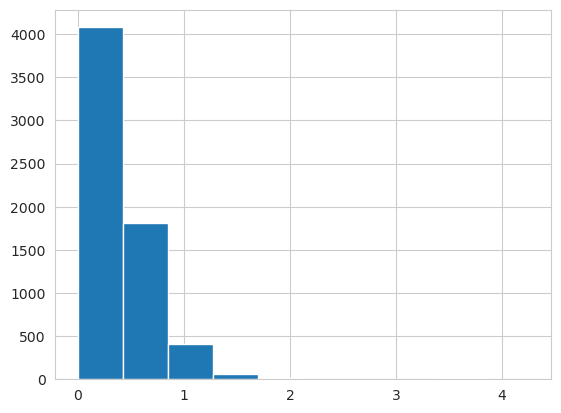

In [100]:
valid_df_1["error"].hist()

In [101]:
import os

valid_df_2 = pd.read_excel(os.path.join("test.xlsx"),
     engine='openpyxl')    

In [102]:
columns = list(valid_df_2.columns)[0].split(",")

In [103]:
valid_df_2.shape

(700, 1)

In [104]:
valid_df_2.iloc[0].values

array(['1582711200,59.93486250245379,30.331615568295643,0101000020E61000009BAC04C2E4543E40DB251193A9F74D40,7,0.3702647438656909'],
      dtype=object)

In [105]:
hour = [int((valid_df_2.iloc[i].values)[0].split(",")[0]) for i in range(valid_df_2.shape[0])]
lat = [(valid_df_2.iloc[i].values)[0].split(",")[1] for i in range(valid_df_2.shape[0])]
lon = [(valid_df_2.iloc[i].values)[0].split(",")[2] for i in range(valid_df_2.shape[0])]
point = [(valid_df_2.iloc[i].values)[0].split(",")[3] for i in range(valid_df_2.shape[0])]
pub_true = [float((valid_df_2.iloc[i].values)[0].split(",")[4]) for i in range(valid_df_2.shape[0])]
error = [float((valid_df_2.iloc[i].values)[0].split(",")[5]) for i in range(valid_df_2.shape[0])]

In [106]:
valid_df_2 = pd.DataFrame({columns[0]: hour, 
                           columns[1]: lat,
                           columns[2]: lon,
                           columns[3]: point,
                           columns[4]: pub_true,
                           columns[5]: error
                          })

In [107]:
valid_df_2.head(10)

,hour,lat,lon,point,sum,error
0,1582711200,59.93486250245379,30.331615568295643,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7.0,0.370265
1,1581937200,59.94048754777036,30.32936978008534,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6.0,0.754735
2,1581523200,59.90559688321354,30.29792874514116,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5.0,3.754735
3,1581512400,59.9213585004893,30.35631923860893,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16.0,4.088069
4,1581771600,59.939362615035215,30.315895050823546,0101000020E61000006141807FDE503E40A554BF083DF8...,10.0,2.088069
5,1580731200,59.8965868842863,30.511278625119544,0101000020E61000004408EE27E3823E401F04E95BC3F2...,5.0,2.010854
6,1582207200,59.938237644136834,30.322632415454443,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,10.0,1.254735
7,1581058800,60.034845742999664,30.419201308497296,0101000020E6100000B16FE6C6506B3E40504B47D37504...,7.0,2.254735
8,1581670800,60.00454565787229,30.300174533351456,0101000020E610000029D6FB3CD84C3E403DF3BDF39400...,8.0,2.754735
9,1581926400,59.83119125766128,30.500049684068053,0101000020E61000008A728F4103803E402A30A27964EA...,5.0,3.754735


In [108]:
FILE_NAME_VALID2 = "valid_2"

In [109]:
valid_models(predict_df, valid_df_2, FILE_NAME_VALID2)

In [110]:
valid_df_2 = pd.read_csv(f"{FILE_NAME_VALID2}.log", sep=";")
valid_df_2.head(10)

,hour,point,pred_sum,true_sum,error
0,1582711200,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,2,7.0,0.714286
1,1582102800,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,2,6.0,0.666667
2,1581001200,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,3,5.0,0.400000
3,1582369200,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,2,5.0,0.600000
4,1582488000,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,3,6.0,0.500000
5,1581015600,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,3,7.0,0.571429
6,1581937200,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,4,6.0,0.333333
7,1582988400,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,5,8.0,0.375000
8,1582905600,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,4,7.0,0.428571
9,1580670000,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,8.0,0.250000


In [111]:
print("Average metric:", sum(valid_df_2["error"]) / len(valid_df_2["error"]))
print("MAE:", MAE(valid_df_2["true_sum"], valid_df_2["pred_sum"]))

Average metric: 0.37217772587727205
MAE: 3.935374149659864


In [112]:
valid_df_2["error"].describe()

count    7056.000000
mean        0.372178
std         0.281101
min         0.000000
25%         0.166667
50%         0.333333
75%         0.533333
max         2.166667
Name: error, dtype: float64

<AxesSubplot:>

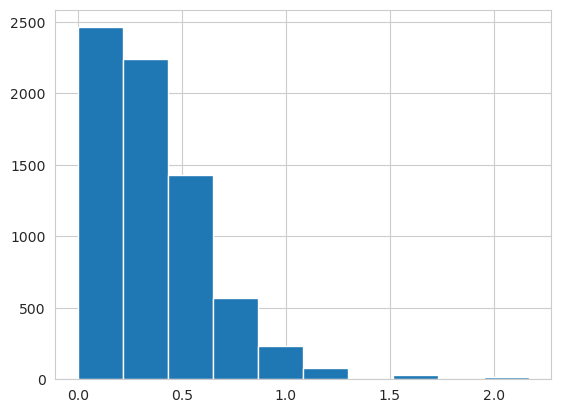

In [113]:
valid_df_2["error"].hist()

### Visualization

In [233]:
point_1 = "0101000020E6100000669634C7914E3E407AB3D8B484F74D40"
point_2 = valid_df_2["point"][2]

In [231]:
# Load models
model_1 = CatBoostRegressor()
model_2 = CatBoostRegressor()

model_1.load_model(f"Models/{point_1}_optFalse")
model_2.load_model(f"Models/{point_2}_optFalse")

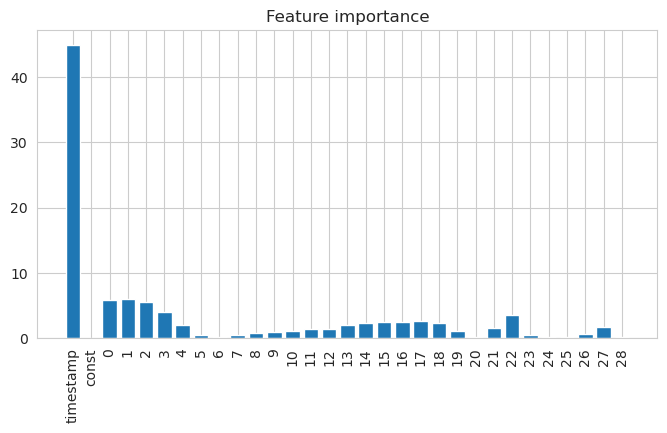

In [242]:
feature_importance = model_1.get_feature_importance()
feature_names = model_1.feature_names_
 
# Visualization of the importance of features

plt.figure(figsize=(8,4))
plt.title("Feature importance")
plt.bar(feature_names, feature_importance)
plt.xticks(rotation=90)
plt.show()

In [235]:
# Get predictions
pred_1 = predict_df[predict_df["point"]==point_1]["predict"]
pred_2 = predict_df[predict_df["point"]==point_2]["predict"]

valid_1 = valid_df_1[valid_df_1["point"]==point_1]
test_2 = valid_df_2[valid_df_2["point"]==point_2]

# Get train data
for i, pt in enumerate(train_df["points"]):
    if point_1 == pt:
        point_id_1 = i
for i, pt in enumerate(train_df["points"]):
    if point_2 == pt:
        point_id_2 = i
        
train_1 = train_df["groups"][point_id_1]
train_2 = train_df["groups"][point_id_2]

In [219]:
valid_1

,hour,point,pred_sum,true_sum,error
29,1582779600,0101000020E6100000669634C7914E3E407AB3D8B484F7...,21,14,0.500000
30,1581609600,0101000020E6100000669634C7914E3E407AB3D8B484F7...,45,35,0.285714
31,1582938000,0101000020E6100000669634C7914E3E407AB3D8B484F7...,1,5,0.800000
32,1581757200,0101000020E6100000669634C7914E3E407AB3D8B484F7...,45,27,0.666667
33,1581019200,0101000020E6100000669634C7914E3E407AB3D8B484F7...,46,37,0.243243
...,...,...,...,...,...
6313,1581307200,0101000020E6100000669634C7914E3E407AB3D8B484F7...,13,10,0.300000
6314,1581368400,0101000020E6100000669634C7914E3E407AB3D8B484F7...,32,22,0.454545
6315,1581976800,0101000020E6100000669634C7914E3E407AB3D8B484F7...,17,37,0.540541
6316,1580752800,0101000020E6100000669634C7914E3E407AB3D8B484F7...,54,35,0.542857


In [236]:
test_2

,hour,point,pred_sum,true_sum,error
0,1582711200,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,2,7.0,0.714286
1,1582102800,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,2,6.0,0.666667
2,1581001200,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,3,5.0,0.400000
3,1582369200,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,2,5.0,0.600000
4,1582488000,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,3,6.0,0.500000
5,1581015600,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,3,7.0,0.571429
2027,1582711200,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,2,7.0,0.714286
2028,1582102800,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,2,6.0,0.666667
2029,1581001200,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,3,5.0,0.400000
2030,1582369200,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,2,5.0,0.600000


In [237]:
all_timestamps = [datetime.datetime.fromtimestamp(timestamp) for timestamp in train_1.index]
pred_timestamps = np.array([(all_timestamps[-1] + datetime.timedelta(hours=i)).strftime("%Y-%m-%d %H:%M:%S") 
                                         for i in range(1, NUM_PRED+1)])

pred_timestamps = [datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S") for timestamp in pred_timestamps]

valid_1_timestamps = [datetime.datetime.fromtimestamp(timestamp) for timestamp in valid_1["hour"]]
test_2_timestamps = [datetime.datetime.fromtimestamp(timestamp) for timestamp in test_2["hour"]]

Text(0, 0.5, 'The number of publications')

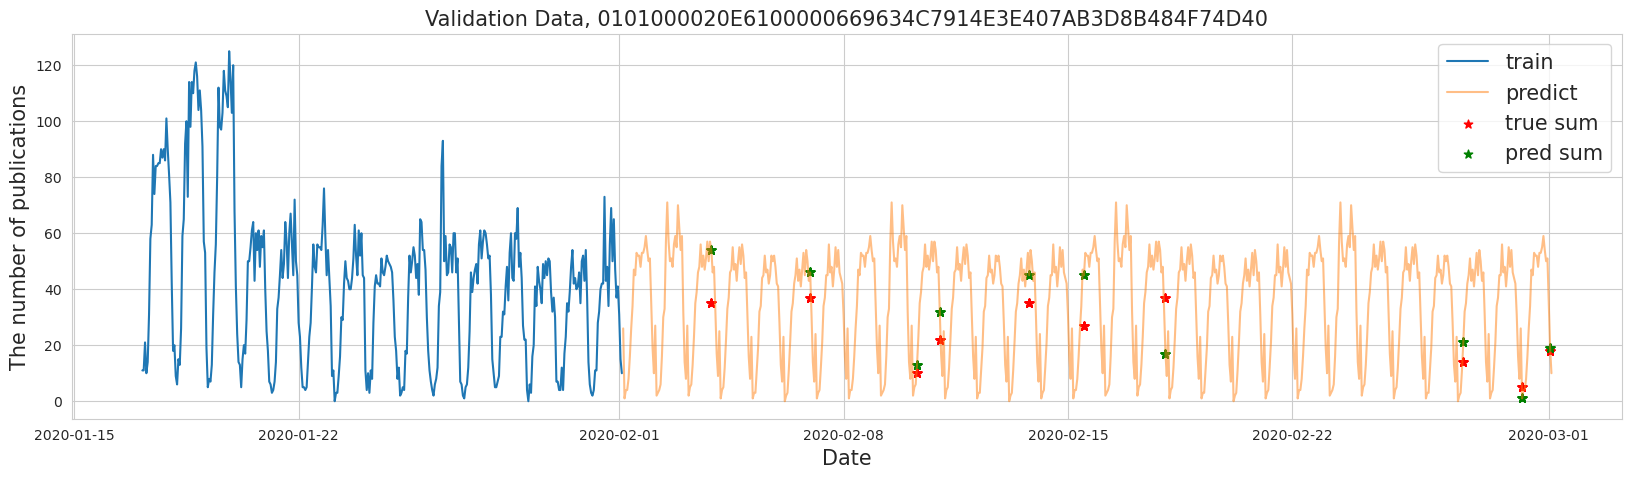

In [238]:
plt.figure(figsize=(20,5))
plt.plot(all_timestamps[-15 * 24:], train_1.values[-15 * 24:], label="train")
plt.plot(pred_timestamps, pred_1.values[0], label="predict", alpha=0.5)
plt.scatter(valid_1_timestamps, valid_1["true_sum"], marker="*", s=40, color="red", label="true sum")
plt.scatter(valid_1_timestamps, valid_1["pred_sum"], marker="*", s=40, color="green", label="pred sum")
plt.legend(fontsize="15")
plt.title(f"Validation Data, {point_1}", fontsize="15")
plt.xlabel("Date", fontsize="15")
plt.ylabel("The number of publications", fontsize="15")

Text(0, 0.5, 'The number of publications')

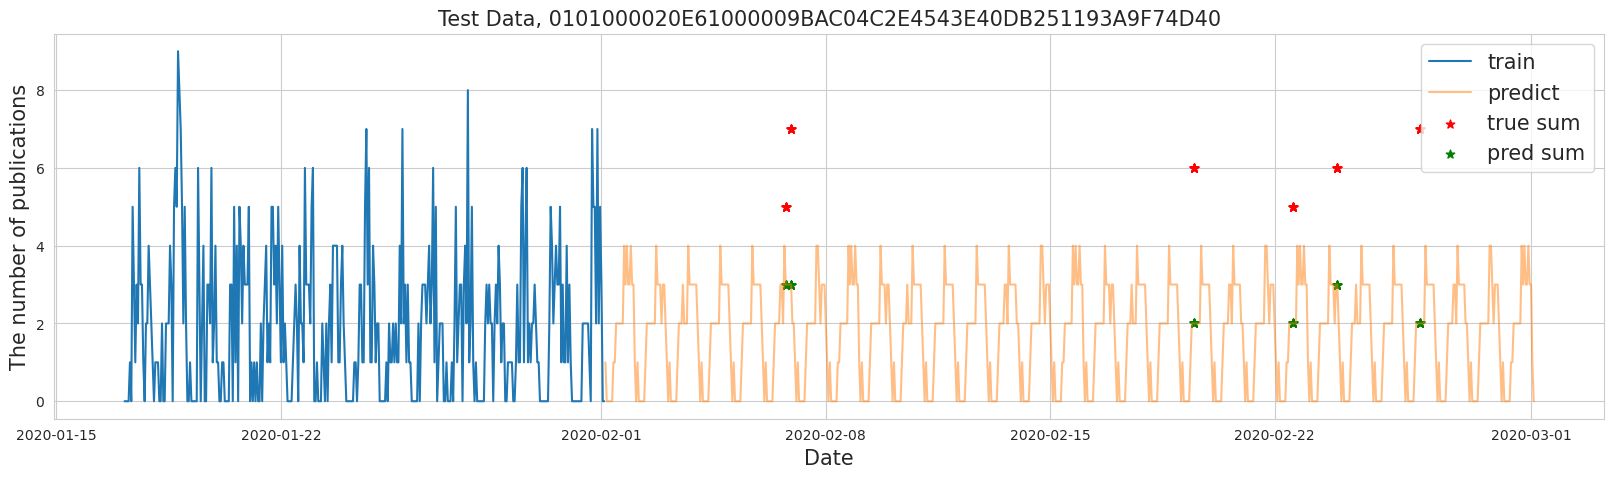

In [243]:
plt.figure(figsize=(20,5))
plt.plot(all_timestamps[-15 * 24:], train_2.values[-15 * 24:], label="train")
plt.plot(pred_timestamps, pred_2.values[0], label="predict", alpha=0.5)
plt.scatter(test_2_timestamps, test_2["true_sum"], marker="*", s=40, color="red", label="true sum")
plt.scatter(test_2_timestamps, test_2["pred_sum"], marker="*", s=40, color="green", label="pred sum")
plt.legend(fontsize="15")
plt.title(f"Test Data, {point_2}", fontsize="15")
plt.xlabel("Date", fontsize="15")
plt.ylabel("The number of publications", fontsize="15")